 In this Release we chqnge the following:
 - eliminate concat between input pitch/rythm and manager output; 
 - output is given in two ways by the manager;
 - 

In [53]:
import tensorflow as tf
import numpy as np
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, GRU, LSTM
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.layers.merge import Concatenate


class ArchitectureSetting():
    def __init__(self):
        
        self.Tx = 11
        self.non_trainable_first = 10
        
        self.manager_internal_shape = 50
        self.pitch_internal_shape = 50
        self.rythm_internal_shape = 50
        
        self.pitch_output_shape = 25
        self.rythm_output_shape = 5
        
        self.pitch_to_manager_shape = 25
        self.rythm_to_manager_shape = 25
        
        self.manager_to_inter_pitch_shape = 40
        self.manager_to_inter_rythm_shape = 20
        
        self.manager_gru = GRU(self.manager_internal_shape, return_state = False)
        self.pitch_gru = GRU(self.pitch_internal_shape, return_state = False)
        self.rythm_gru = GRU(self.rythm_internal_shape, return_state = False)

        self.pitch_to_manager = Dense(self.pitch_to_manager_shape, activation='tanh')
        self.rythm_to_manager = Dense(self.rythm_to_manager_shape, activation='tanh')

        self.manager_to_inter_pitch = Dense(self.manager_to_inter_pitch_shape, activation='tanh')
        self.manager_to_inter_rythm = Dense(self.manager_to_inter_rythm_shape, activation = 'tanh')
        
        self.inter_to_pitch = Dense(self.pitch_output_shape, activation = 'softmax')
        self.inter_to_rythm = Dense(self.rythm_output_shape, activation = 'softmax')



def build_model(setting):


    
    X_pitch = Input(shape = (setting.Tx, setting.pitch_output_shape), name = 'X_pitch')
    X_rythm = Input(shape = (setting.Tx, setting.rythm_output_shape), name = 'X_rythm')
    
    reshapor_pitch = Reshape((setting.pitch_output_shape, 1))#?
    reshapor_rythm = Reshape((setting.rythm_output_shape, 1))
    
    manager_state_0 = Input(shape=(setting.manager_internal_shape, ), name = 'manager_state_0')
    pitch_state_0 = Input(shape = (setting.pitch_internal_shape, ), name = 'pitch_state_0')
    rythm_state_0 = Input(shape = (setting.rythm_internal_shape, ), name = 'rythm_state_0')

    manager_state = manager_state_0
    pitch_state = pitch_state_0
    rythm_state = rythm_state_0
    
    reshapor_concat = Reshape((setting.pitch_to_manager_shape + setting.rythm_to_manager_shape, 1))
    

    out_pitches = []
    out_rythms = []

    for t in range(Tx):
        print(t)
        
        ################################################
        get_pitch_t =  Lambda(lambda x: reshapor_pitch(x[:, t, :])) 
        get_rythm_t = Lambda(lambda x: reshapor_rythm(x[:, t, :]))  

        pitch_state = setting.pitch_gru(get_pitch_t(X_pitch), initial_state = [pitch_state])
        rythm_state = setting.rythm_gru(get_rythm_t(X_rythm), initial_state = [rythm_state])
        
        
        concat = reshapor_concat(Concatenate(axis = 1)([setting.pitch_to_manager(pitch_state),\
                                                        setting.rythm_to_manager(rythm_state)]))
        
        manager_state = setting.manager_gru(concat, initial_state = [manager_state])
        
        if (t >= setting.non_trainable_first):

            out_pitches.append(setting.inter_to_pitch(setting.manager_to_inter_pitch(manager_state)))
            out_rythms.append(setting.inter_to_rythm(setting.manager_to_inter_rythm(manager_state)))
        
        
        

        out = out_pitches + out_rythms

    model_general = Model(inputs = [X_pitch, X_rythm, pitch_state_0, rythm_state_0, manager_state_0], outputs = out)

    return model_general


setting = ArchitectureSetting()
model = build_model(setting)

from keras.losses import categorical_crossentropy#(y_true, y_pred)
from keras import backend as K
def custom_objective(y_true, y_pred):
    #print(y_true.shape)
    #print(y_pred.shape)
    length_out = y_pred.shape[1] // 2
    return K.mean(categorical_crossentropy(y_true[:,:length_out], y_pred[:,:length_out]) + categorical_crossentropy(y_true[:,length_out:], y_pred[:,length_out:]))

opt = Adam()#lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01

model.compile(optimizer=opt, loss=custom_objective, metrics=['accuracy'])

0
1
2
3
4
5
6
7
8
9
10


In [36]:
import pickle
from keras.utils import np_utils

rythm_X = pickle.load(open( "jazz_rythm.txt", "rb" ), encoding = 'bytes')
pitch_X = pickle.load(open( "jazz_pitch.txt", "rb" ), encoding = 'bytes')

non_trainable_first = setting.non_trainable_first
Tx = setting.Tx

pitch_output_shape = setting.pitch_output_shape
rythm_output_shape = setting.rythm_output_shape

X_pitch = []
X_rythm = []

y_pitch = []
y_rythm = []

encode_lengths = {1:0, 2:1, 4:2, 8:3, 16:4}

def enc_l(arr):
    return [encode_lengths[x] for x in arr]

for pitch_s, rythm_s in zip(pitch_X, rythm_X):
    lgth = (len(pitch_s) - 1) // Tx
    for i in range(lgth):
        
        
        X_pitch.append(np_utils.to_categorical(pitch_s[i * Tx: (i + 1) * Tx],pitch_output_shape ))
        y_pitch.append(np_utils.to_categorical(pitch_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx: (i + 1) * Tx]),rythm_output_shape))
        y_rythm.append(np_utils.to_categorical(enc_l(rythm_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1]),rythm_output_shape))

Y = [list(y_pitch[i])+list(y_rythm[i]) for i in range(len(y_pitch))]#
Y = [np.array([y[i] for y in Y[:4000]]) for i in range(2)]

X_pitch_np = np.array(X_pitch)[:4000]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)[:4000]

from keras.callbacks import ModelCheckpoint

m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((m, pitch_internal_shape))
rythm_state_0 = np.zeros((m, rythm_internal_shape))
manager_state_0 = np.zeros((m, manager_internal_shape))



model.fit([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0], Y, batch_size = 100, epochs=1, verbose = 1, shuffle = True)


Epoch 1/1
4000/4000 [==============================] - 41s 10ms/step - loss: 2.9530 - dense_87_loss: 2.3639 - dense_88_loss: 0.5891 - dense_87_acc: 0.1948 - dense_88_acc: 0.7415


In [ ]:
rythm_X[0]

In [ ]:
#Y = [[y_pitch[i], y_rythm[i]] for i in range(len(y_pitch))] 
np.array([len(y) for y in y_pitch])[np.array([len(y) for y in y_pitch]) != 1]

In [ ]:
Y[0][0].shape

In [ ]:
np.min(X_pitch_np[0],axis = 1)

In [ ]:
len(X_pitch)

In [ ]:
model.summ

In [ ]:
X_pitch, X_rythm, pitch_state_0, rythm_state_0, manager_state_0

In [ ]:
model.summary()

In [41]:
def make_prediction(setting, to_generate):

    X_pitch = Input(shape = (setting.Tx, setting.pitch_output_shape), name = 'X_pitch')
    X_rythm = Input(shape = (setting.Tx, setting.rythm_output_shape), name = 'X_rythm')
    
    reshapor_pitch = Reshape((setting.pitch_output_shape, 1))#?
    reshapor_rythm = Reshape((setting.rythm_output_shape, 1))
    
    manager_state_0 = Input(shape=(setting.manager_internal_shape, ), name = 'manager_state_0')
    pitch_state_0 = Input(shape = (setting.pitch_internal_shape, ), name = 'pitch_state_0')
    rythm_state_0 = Input(shape = (setting.rythm_internal_shape, ), name = 'rythm_state_0')

    manager_state = manager_state_0
    pitch_state = pitch_state_0
    rythm_state = rythm_state_0
    
    reshapor_pitch = Reshape((setting.pitch_output_shape, 1))
    reshapor_rhythm = Reshape((setting.rythm_output_shape, 1))
    
    reshapor_concat = Reshape((setting.pitch_to_manager_shape + setting.rythm_to_manager_shape, 1))
    

    out_pitches = []
    out_rythms = []


    for t in range(non_trainable_first):
        #print(t)

        get_pitch_t =  Lambda(lambda x: reshapor_pitch(x[:, t, :])) 
        get_rythm_t = Lambda(lambda x: reshapor_rythm(x[:, t, :]))  

        pitch_state = setting.pitch_gru(get_pitch_t(X_pitch), initial_state = [pitch_state])
        rythm_state = setting.rythm_gru(get_rythm_t(X_rythm), initial_state = [rythm_state])
        
        
        concat = reshapor_concat(Concatenate(axis = 1)([setting.pitch_to_manager(pitch_state),\
                                                        setting.rythm_to_manager(rythm_state)]))
        
        manager_state = setting.manager_gru(concat, initial_state = [manager_state])
    
        output_pitch = setting.inter_to_pitch(setting.manager_to_inter_pitch(manager_state))
        output_rythm = setting.inter_to_rythm(setting.manager_to_inter_rythm(manager_state))
        

    

    for t in range(to_generate):
        #print(t)
        
        #Sample pitch
        pitch = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), pitch_output_shape))#np.random.choice(pitch_output_shape, output_pitch)
        #pitch = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis = 1), pitch_output_shape))

        
        #Sample rythm        
        rythm = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), rythm_output_shape))
        #rythm = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis = 1), rythm_output_shape))
        
        pitch_sampled = reshapor_pitch(pitch(output_pitch))
        rythm_sampled = reshapor_rythm(rythm(output_rythm))
        
        #print(pitch_sampled)
        out_pitches.append(pitch_sampled)
        out_rythms.append(rythm_sampled)
        #####################################
        
        pitch_state = setting.pitch_gru(pitch_sampled, initial_state = [pitch_state])
        rythm_state = setting.rythm_gru(rythm_sampled, initial_state = [rythm_state])
        
        concat = reshapor_concat(Concatenate(axis = 1)([setting.pitch_to_manager(pitch_state),\
                                                setting.rythm_to_manager(rythm_state)]))
        
        manager_state = setting.manager_gru(concat, initial_state = [manager_state])
        
        
        output_pitch = setting.inter_to_pitch(setting.manager_to_inter_pitch(manager_state))
        output_rythm = setting.inter_to_rythm(setting.manager_to_inter_rythm(manager_state))
        

        

    out = out_pitches + out_rythms

    model_general = Model(inputs = [X_pitch, X_rythm, pitch_state_0, rythm_state_0, manager_state_0], outputs = out)

    return model_general

In [42]:
number_of_notes_to_generate = 25
model_predict = make_prediction(setting, number_of_notes_to_generate)

In [51]:
#m = X_pitch_np.shape[0]

manager_internal_shape = setting.manager_internal_shape
pitch_internal_shape = setting.pitch_internal_shape
rythm_internal_shape = setting.rythm_internal_shape

pitch_state_0 = np.zeros((1, pitch_internal_shape))
rythm_state_0 = np.zeros((1, rythm_internal_shape))
manager_state_0 = np.zeros((1, manager_internal_shape))

X_pitch_np = np.array(X_pitch)[1000,:setting.Tx].reshape((1,setting.Tx,setting.pitch_output_shape))
X_rythm_np = np.array(X_rythm)[1000,:setting.Tx].reshape((1,setting.Tx,setting.rythm_output_shape))
#X_pitch_np = [np.argmax(x) for x in X_pitch_np]
#X_rythm_np = [np.argmax(x) for x in X_rythm_np]

result = model_predict.predict([X_pitch_np, X_rythm_np,  pitch_state_0, rythm_state_0, manager_state_0])

[0, 1, 2, 3, 4, 0, 0, 4, 3, 3, 4, 2, 0, 3, 3, 0, 0, 2, 0, 3, 4, 1, 3, 4, 1]
[9, 3, 16, 2, 8, 0, 23, 12, 24, 5, 8, 8, 0, 12, 4, 16, 21, 3, 12, 21, 12, 3, 7, 23, 10]


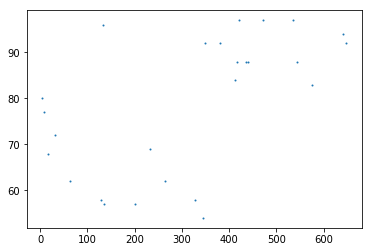

0


In [52]:

seq_p = result[:number_of_notes_to_generate]
seq_r = result[number_of_notes_to_generate:]



X_pitch_np = [np.argmax(x) for x in seq_p]
X_rythm_np = [np.argmax(x) for x in seq_r]

print(X_rythm_np)
print(X_pitch_np)
create_track_new(X_rythm_np,X_pitch_np)

In [ ]:
X_pitch_np = np.array(X_pitch)[2035,:8].reshape((1,8,25))
X_rythm_np = np.array(X_rythm)[2035,:8].reshape((1,8,5))
np.argmax(X_pitch_np, axis = 2)

In [ ]:
seq_p = result[:number_of_notes_to_generate]
seq_r = result[number_of_notes_to_generate:]



X_pitch_np = [np.argmax(x) for x in seq_p]
X_rythm_np = [np.argmax(x) for x in seq_r]

print(X_rythm_np)
print(X_pitch_np)
create_track_new(X_rythm_np,X_pitch_np)

In [29]:
from midiutil import MIDIFile
import matplotlib.pyplot as plt


def create_track_new(seq, seq_pitch):
    
    #num_to_len = {1:1, 2:2, 3:4, 4:8, 5:16, 6:32}
    grain = 32
    one_tact = 128
    tacts_per_min = 75
    tempo    = one_tact * tacts_per_min  # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    track    = 0
    channel  = 0
    time     = 0# to learn
    
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    
    MyMIDI.addNote(track, channel, 120, 0, one_tact / grain, volume)
    tick_count = one_tact / grain
    
    current_pitch = 80
    
    tick_counts = [tick_count]
    pitches = [current_pitch]
    
    decode_lengths  = {0:1, 1:2, 2:4, 3:8, 4:16}
    for l,p in zip(seq, seq_pitch):
        current_pitch += (p - 12)
        if current_pitch < 50:
            current_pitch += 50
        if current_pitch > 100:
            current_pitch -= 50
        pitches += [current_pitch]
        #length = num_to_len[l]
        MyMIDI.addNote(track, channel, current_pitch, tick_count, one_tact / grain * (decode_lengths[l]), volume)
        tick_count = tick_count + one_tact / grain * (decode_lengths[l])
        tick_counts += [tick_count]
    
    plt.scatter(tick_counts, pitches, s = 1)
    plt.show()
    print(track)

    with open("zzz.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file) 
                
                            
                    



In [ ]:
X_pitch_np = np.array(X_pitch)[12,:8]
X_rythm_np = np.array(X_rythm)[12,:8]
X_pitch_np = [np.argmax(x) for x in X_pitch_np]
X_rythm_np = [np.argmax(x) for x in X_rythm_np]

create_track_new(X_rythm_np, X_pitch_np)
#print(np.max(np.argmax(X_rythm_np, axis = 1),axis = 1))

In [ ]:
np.argmax(X_rythm_np[0])

In [ ]:
np.argmax(X_pitch_np[1])

In [ ]:
import mingus.core.intervals as intervals

In [ ]:
manager_gru(manager_input)

In [ ]:
out = manager_gru(manager_input)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
manager = Model(inputs = [manager_input], outputs = out[:2])
manager.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
out

In [ ]:
manager.predict(np.ones((1,1,100)))

In [ ]:
seq = manager_gru(manager_input).compile()

In [ ]:
pitch_gru(pitch_input)

In [ ]:
import numpy as np

In [ ]:
sess = tf.Session()

In [ ]:
pitch_output_shape = 10

choices_pitch = tf.constant( np.array( [np.arange(pitch_output_shape)]), dtype=tf.int64)

output_pitch = list(np.zeros(pitch_output_shape, dtype = 'int64'))
output_pitch[5] = 0.5
output_pitch[4] = 0.5

output_pitch = tf.constant(output_pitch)
sampled_ids_pitch = tf.multinomial([output_pitch], 12)

In [ ]:
list(np.zeros(pitch_output_shape, dtype = 'int64'))

In [ ]:
with tf.Session() as sess:
    sample = sess.run(sampled_ids_pitch)
    print(sample)
    

In [ ]:
# L has shape [2, 5, 2]
L = tf.constant([[0.9, 0.1]])

dims = L.get_shape().as_list()
N = dims[-1]  # here N = 2

logits = tf.reshape(L, [-1, N])


samples = tf.multinomial(logits, 1)
# We reshape to match the initial shape minus the last dimension
res = tf.reshape(samples, dims[:-1])

In [ ]:
with tf.Session() as sess:
    sample = sess.run(res)
    print(sample)

In [21]:
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen, mins = [(0,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf")


edges = [
    ("A", "B", 7),
    ("A", "D", 5),
    ("B", "C", 8),
    ("B", "D", 9),
    ("B", "E", 7),
    ("C", "E", 5),
    ("D", "E", 15),
    ("D", "F", 6),
    ("E", "F", 8),
    ("E", "G", 9),
    ("F", "G", 11)
]

print ("=== Dijkstra ===")
print (edges)
print ("A -> E:")
print (dijkstra(edges, "A", "E"))
print ("F -> E:")
print (dijkstra(edges, "F", "E"))

=== Dijkstra ===
[('A', 'B', 7), ('A', 'D', 5), ('B', 'C', 8), ('B', 'D', 9), ('B', 'E', 7), ('C', 'E', 5), ('D', 'E', 15), ('D', 'F', 6), ('E', 'F', 8), ('E', 'G', 9), ('F', 'G', 11)]
A -> E:
(14, ('E', ('B', ('A', ()))))
F -> E:
inf


In [28]:
{1:1, "12":3}


{1: 1, '12': 3}

In [16]:
g = Graph()
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_node(4)
g.add_edge(1, 2, 20)
g.add_edge(2, 3, 20)

In [18]:
dijsktra(g,1)

KeyError: (2, 1)

In [27]:
int("+01")

1

In [29]:
from collections import deque

In [30]:
d = deque()

In [34]:
d.appendleft(1)

In [32]:
d


deque([[1, 2, 3, 4]])